# Прогнозирование конечных свойств новых материалов (композиционных материалов). 

Описание: 
Композиционные материалы — это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т. е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента).


В ходе выполнения ВКР требуется сделать:
* Изучить теоретические основы и методы решения поставленной задачи.
* Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
* Провести предобработку данных (удаление шумов, нормализация и т.д.).
* Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
* Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 
* Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз, полученный в задании 4 или 5 (один или два прогноза, на выбор учащегося).
* Оценить точность модели на тренировочном и тестовом датасете. 
* Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.


Имеется датасет со свойствами композита состоящий из двух файлов - X_bp (свойства из базальтопластика) и Х_nup (свойства из углепластика). По условиям задачи дано, что объединение делать по индексу тип объединения INNER.

На входе: имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов.

Актуальность: Созданные прогнозные модели помогут сократить количество проводимых испытаний, а также пополнить базу данных материалов возможными новыми характеристиками материалов, и цифровыми двойниками новых композитов.

**Импортирую необходимые библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras import models
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam

**Загружаем исходные данные**

In [2]:
df_bp = pd.read_excel('X_bp.xlsx', index_col=0)
df_X_nup = pd.read_excel('X_nup.xlsx', index_col=0)

**Проверяем размеры данных**

In [3]:
df_bp.shape

(1023, 10)

df_bp содержит индекс + 10 признаков и 1023 строк

In [4]:
df_X_nup.shape

(1040, 3)

df_X_nup содержит индекс + 3 признака и 1040 строк

**Объеденение данных**

In [5]:
df_merge = df_bp.merge(df_X_nup, how='inner', left_index=True,right_index=True)

In [6]:
#Сохраним объединенный датасет в папку Datasets
df_merge.to_csv('Datasets\Datasets\df_merge_all.csv', encoding = 'cp1251' )

Данные имеют разное количество строк, но по условиям задачи дано, что нужно объеденить по типу INNER

## Разведочный анализ

Необходимо: 
* нарисовать гистограммы распределения каждой из переменной
* диаграммы ящика с усами
* попарные графики рассеяния точек
* для каждой колонке получить среднее и медианное значение
* провести анализ и исключение выбросов
* проверить наличие пропусков

### Шаг 1. Знакомство с данными

In [7]:
df_merge.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0.0                         1.857143            2030.0             738.736842   
1.0                         1.857143            2030.0             738.736842   
2.0                         1.857143            2030.0             738.736842   
3.0                         1.857143            2030.0             738.736842   
4.0                         2.771331            2030.0             753.000000   

     Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0.0                        30.00                        22.267857   
1.0                        50.00                        23.750000   
2.0                        49.90                        33.000000   
3.0                       129.00                        21.250000   
4.0                       111.86                        22.267857   

     Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0.0                100.000000                          210.0   
1.0                284.615385                          210.0   
2.0                284.615385                          210.0   
3.0                300.000000                          210.0   
4.0                284.615385                          210.0   

     Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0.0                                  70.0                         3000.0   
1.0                                  70.0                         3000.0   
2.0                                  70.0                         3000.0   
3.0                                  70.0                         3000.0   
4.0                                  70.0                         3000.0   

     Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  \
0.0                    220.0                 0.0          4.0   
1.0                    220.0                 0.0          4.0   
2.0                    220.0                 0.0          4.0   
3.0                    220.0                 0.0          5.0   
4.0                    220.0                 0.0          5.0   

     Плотность нашивки  
0.0               57.0  
1.0               60.0  
2.0               70.0  
3.0               47.0  
4.0               57.0

In [8]:
df_merge.shape

(1023, 13)

Объедененный датасет имеет 13 признаков и 1023 строки, 17 строк из таблицы X_nup была отброшено, что не является существенным.

**типы признаков**

In [9]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки

Все данные количественные (int и float), качественных значений нет. Пропусков нет

**описательная статистика**

In [10]:
df_merge.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean            44.252199     6.899222          57.153929  
std             45.015793     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%             90.000000     8.586293          64.944961  
max             90.000000    14.440522         103.988901

Описательная статистика содержит по каждому столбцу (по каждой переменной):
*   count - количество значений
*   mean - среднее значение
*   std - стандартное отклонение
*   min - минимум
*   25% - верхнее значение первого квартиля
*   50%	- медиана
*   75% - верхнее значение третьего квартиля
*   max - максимум

### Шаг 2. Пропуски данных

In [11]:
df_merge.isnull().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

**желтый - пропущенные данные, синий - не пропущенные**

<AxesSubplot:>

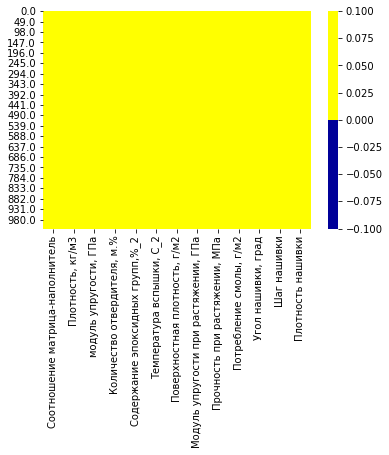

In [12]:
cols = df_merge.columns
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_merge[cols].isnull(), cmap=sns.color_palette(colours))

Тепловая карта, так же как info() и функция ISNULL() показывает что пропусков нет.

### Шаг 3. Дубликаты

In [13]:
df_merge.duplicated().sum()

0

дубликатов данных нет

### Шаг 4. Гистограммы распределения каждой из переменной

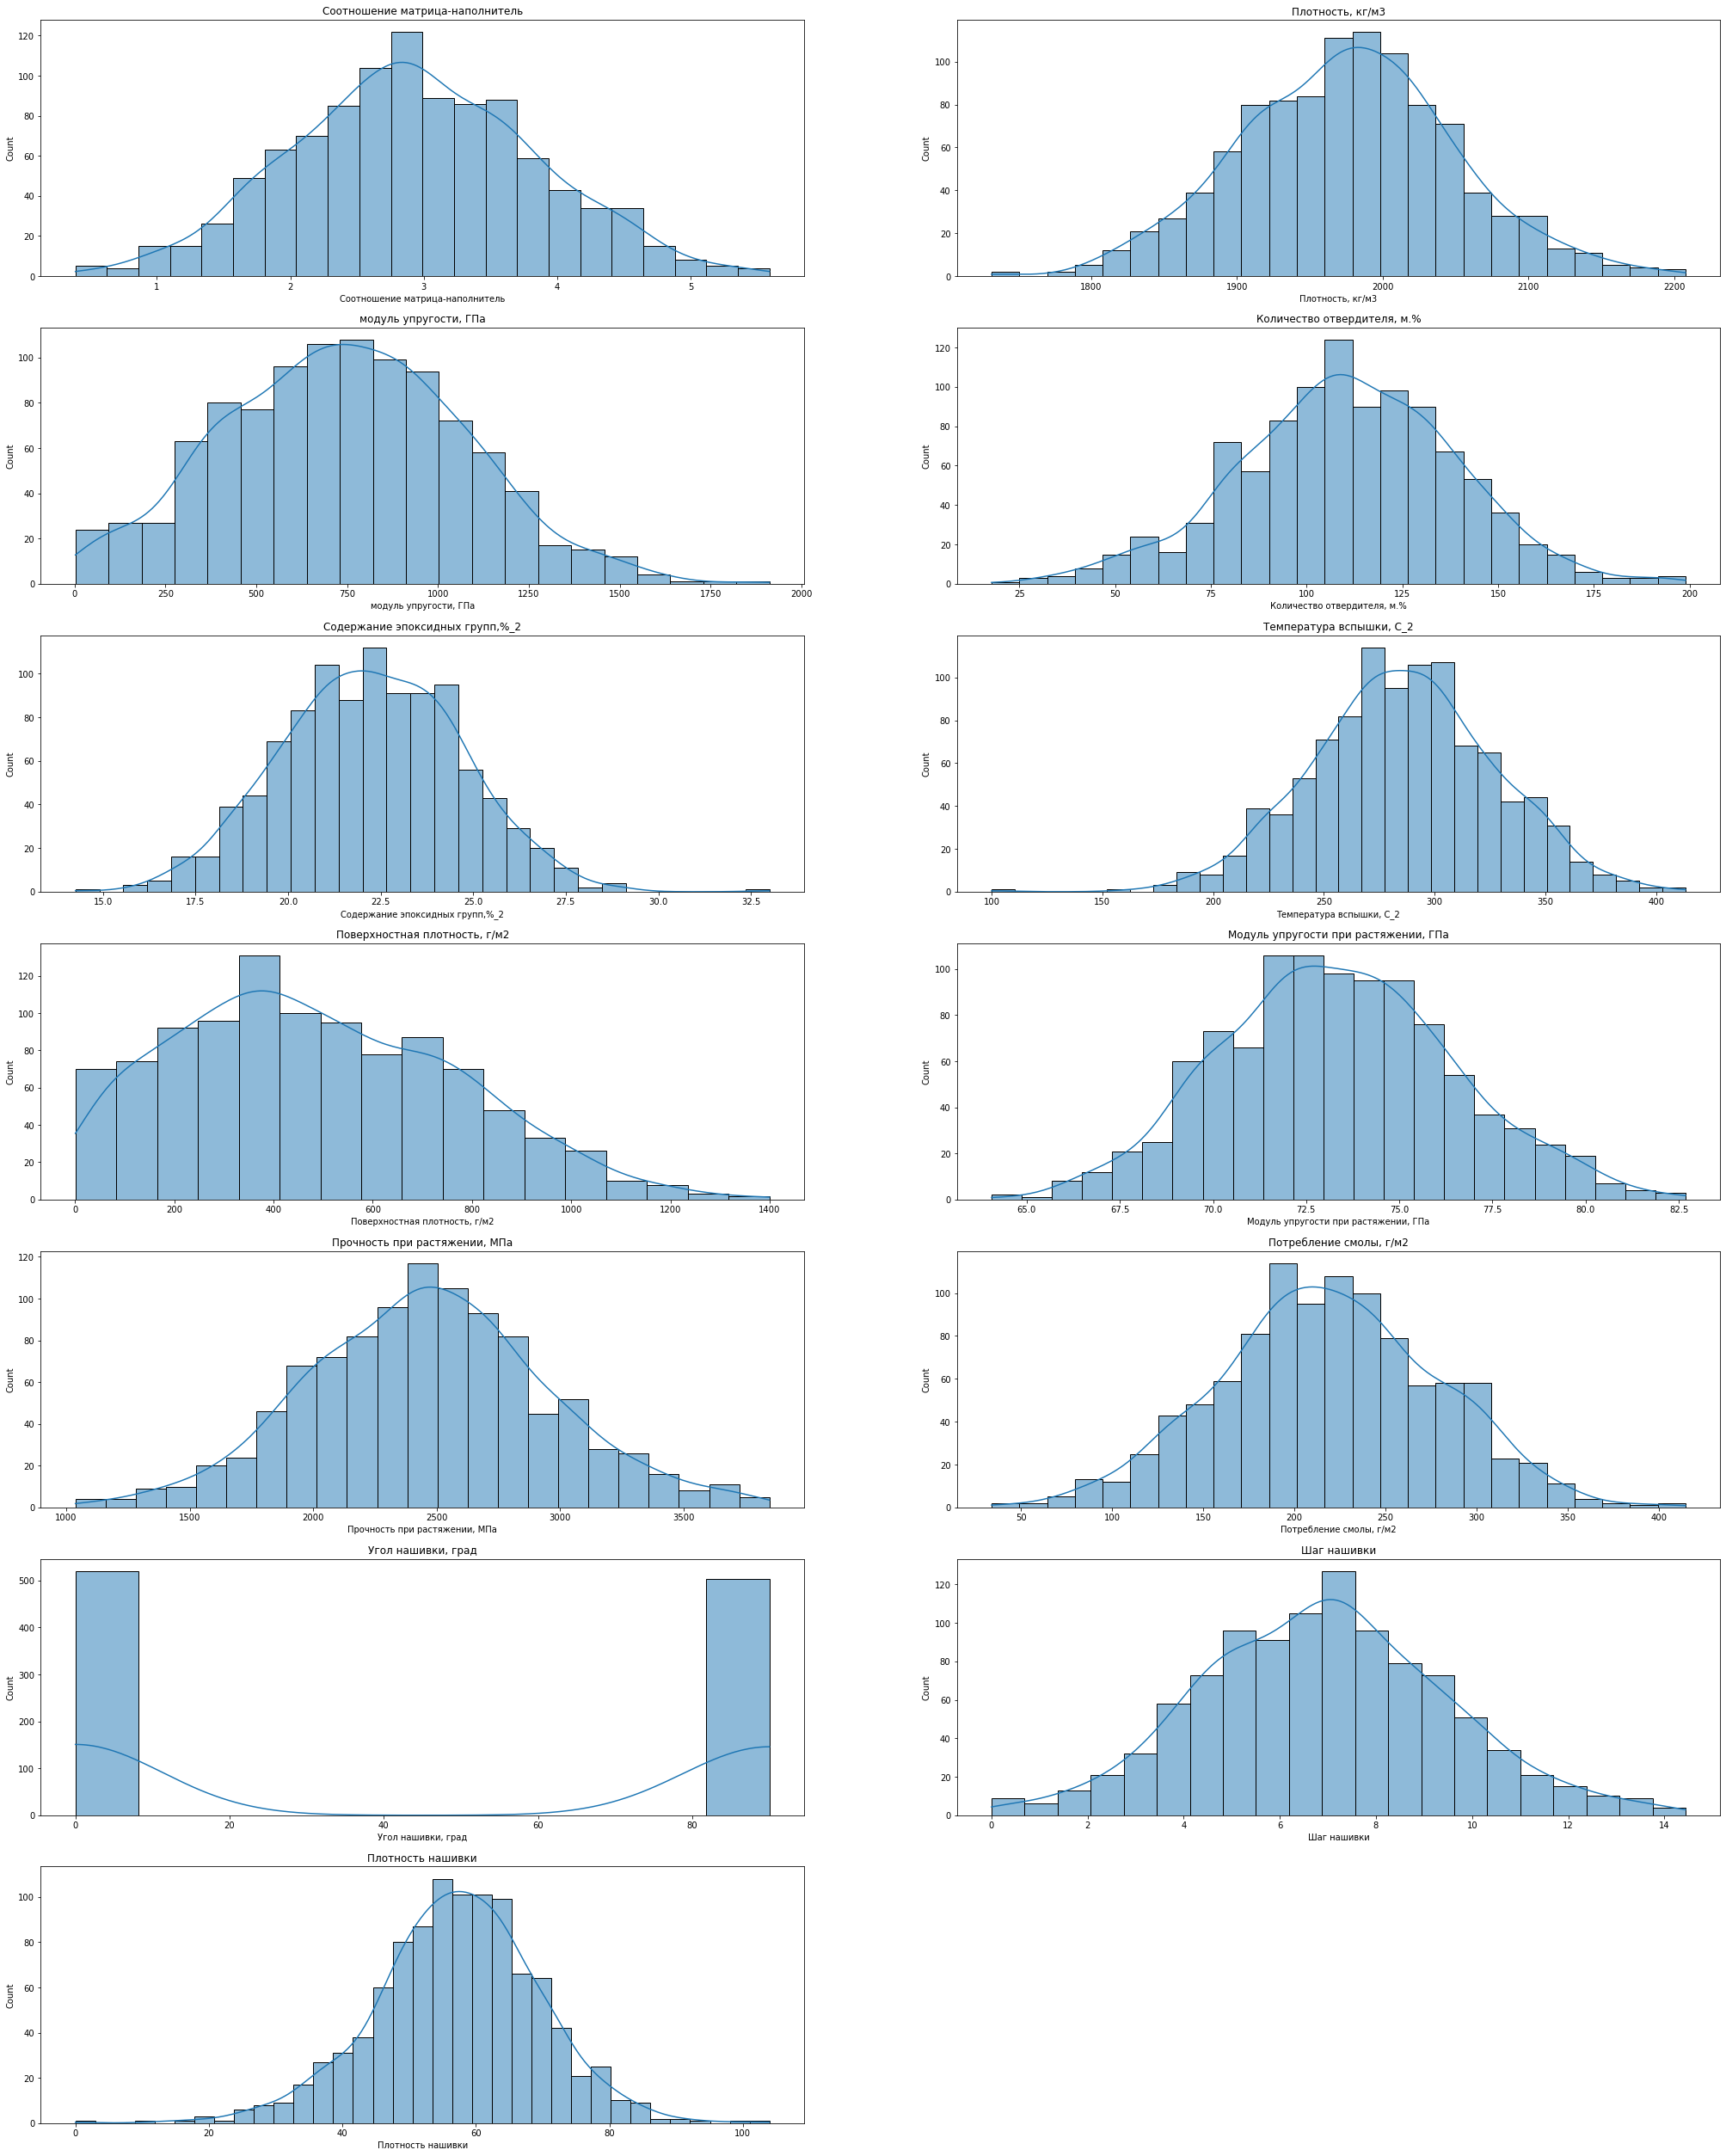

In [14]:
a = 7  # количество строк
b = 2  # количество столцбцов
c = 1  # инициализация plot counter

fig = plt.figure(figsize=(35, 45))

for i in df_merge.columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.histplot(df_merge[i], kde=True,)
    c = c + 1
   
plt.show()

По гистограмме видно, что есть ярко выбросы в столбцах Плотность, содержание эпоксидных групп, температура вспышки, плотность нашивки.
Распределение нормальное (кроме угла нашивки, имеющим только 2 значения). По имеющимся данным что датасет был предварительно подготовлен заказчиком.

### Шаг 5. Диаграммы ящика с усами

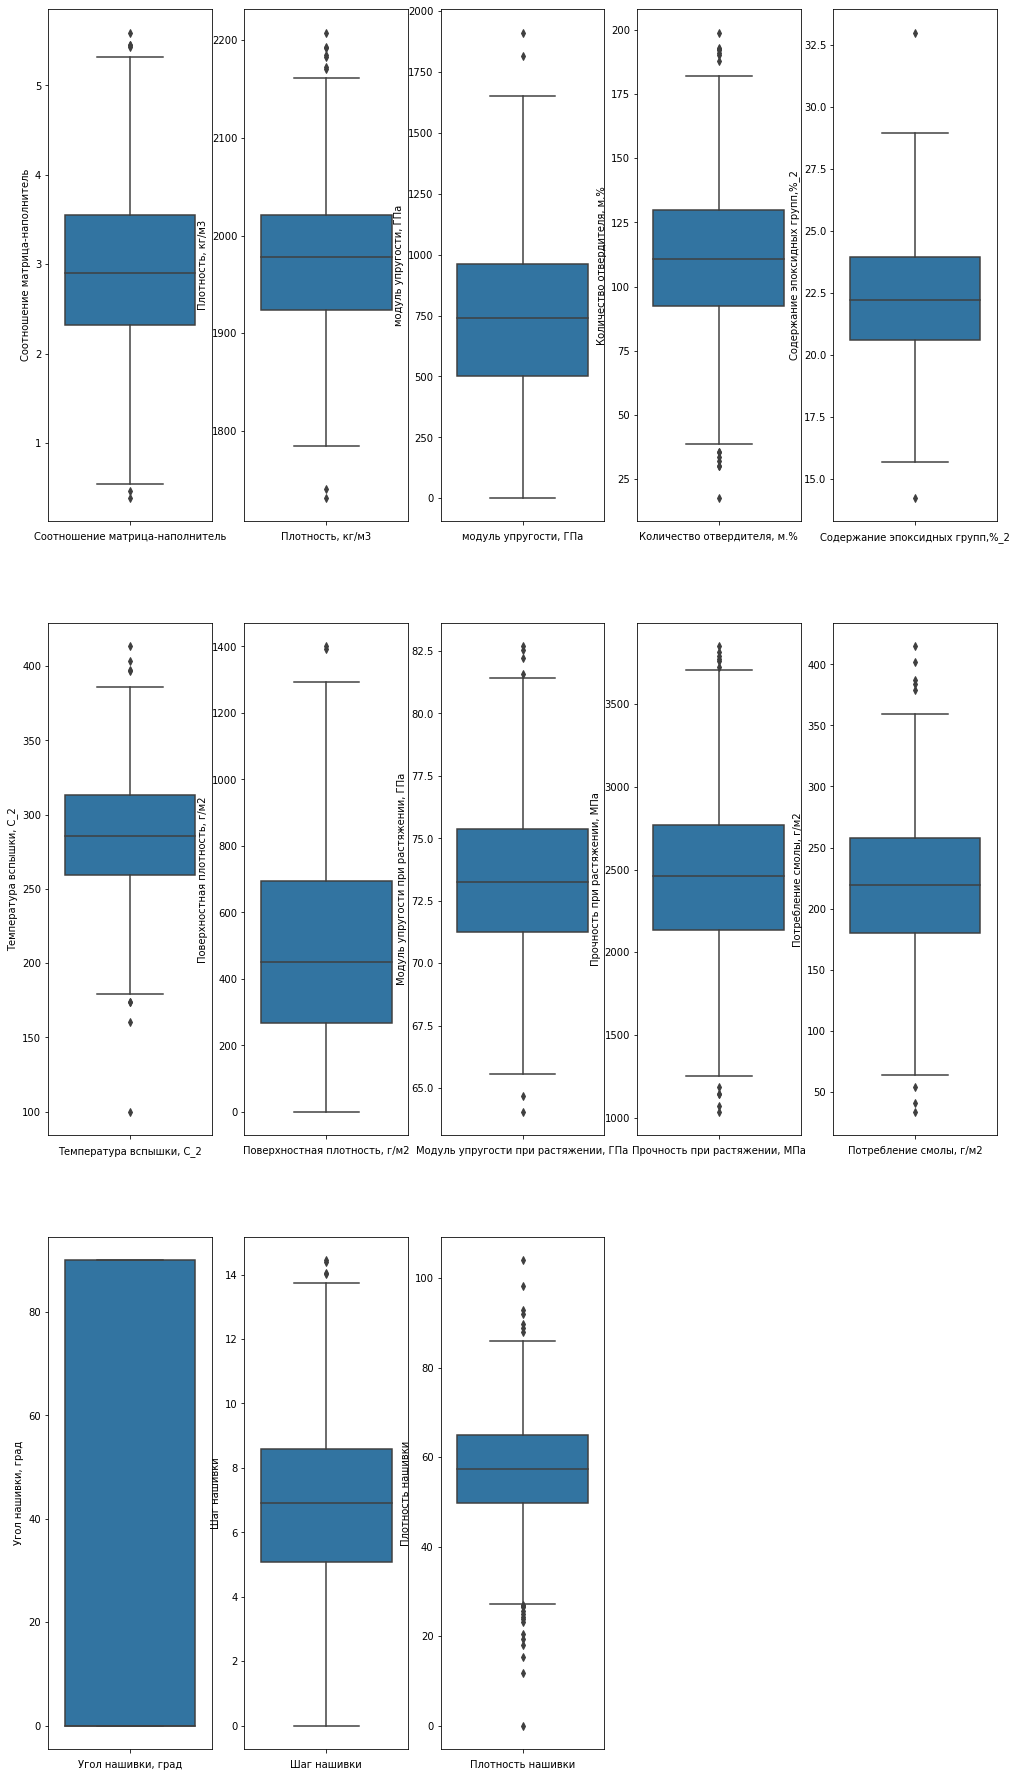

In [15]:
a = 3  # количество строк
b = 5  # количество столцбцов
c = 1  # инициализация plot counter

fig = plt.figure(figsize=(17, 32))

for i in df_merge.columns:
    plt.subplot(a, b, c)
    plt.xlabel(i)
    sns.boxplot(y = df_merge[i])
    c = c + 1
   
plt.show()

Ящик с усами показывает, что выбросы есть во всех показателях, кроме углов нашивки.

### Шаг 6. Попарные графики рассеяния точек

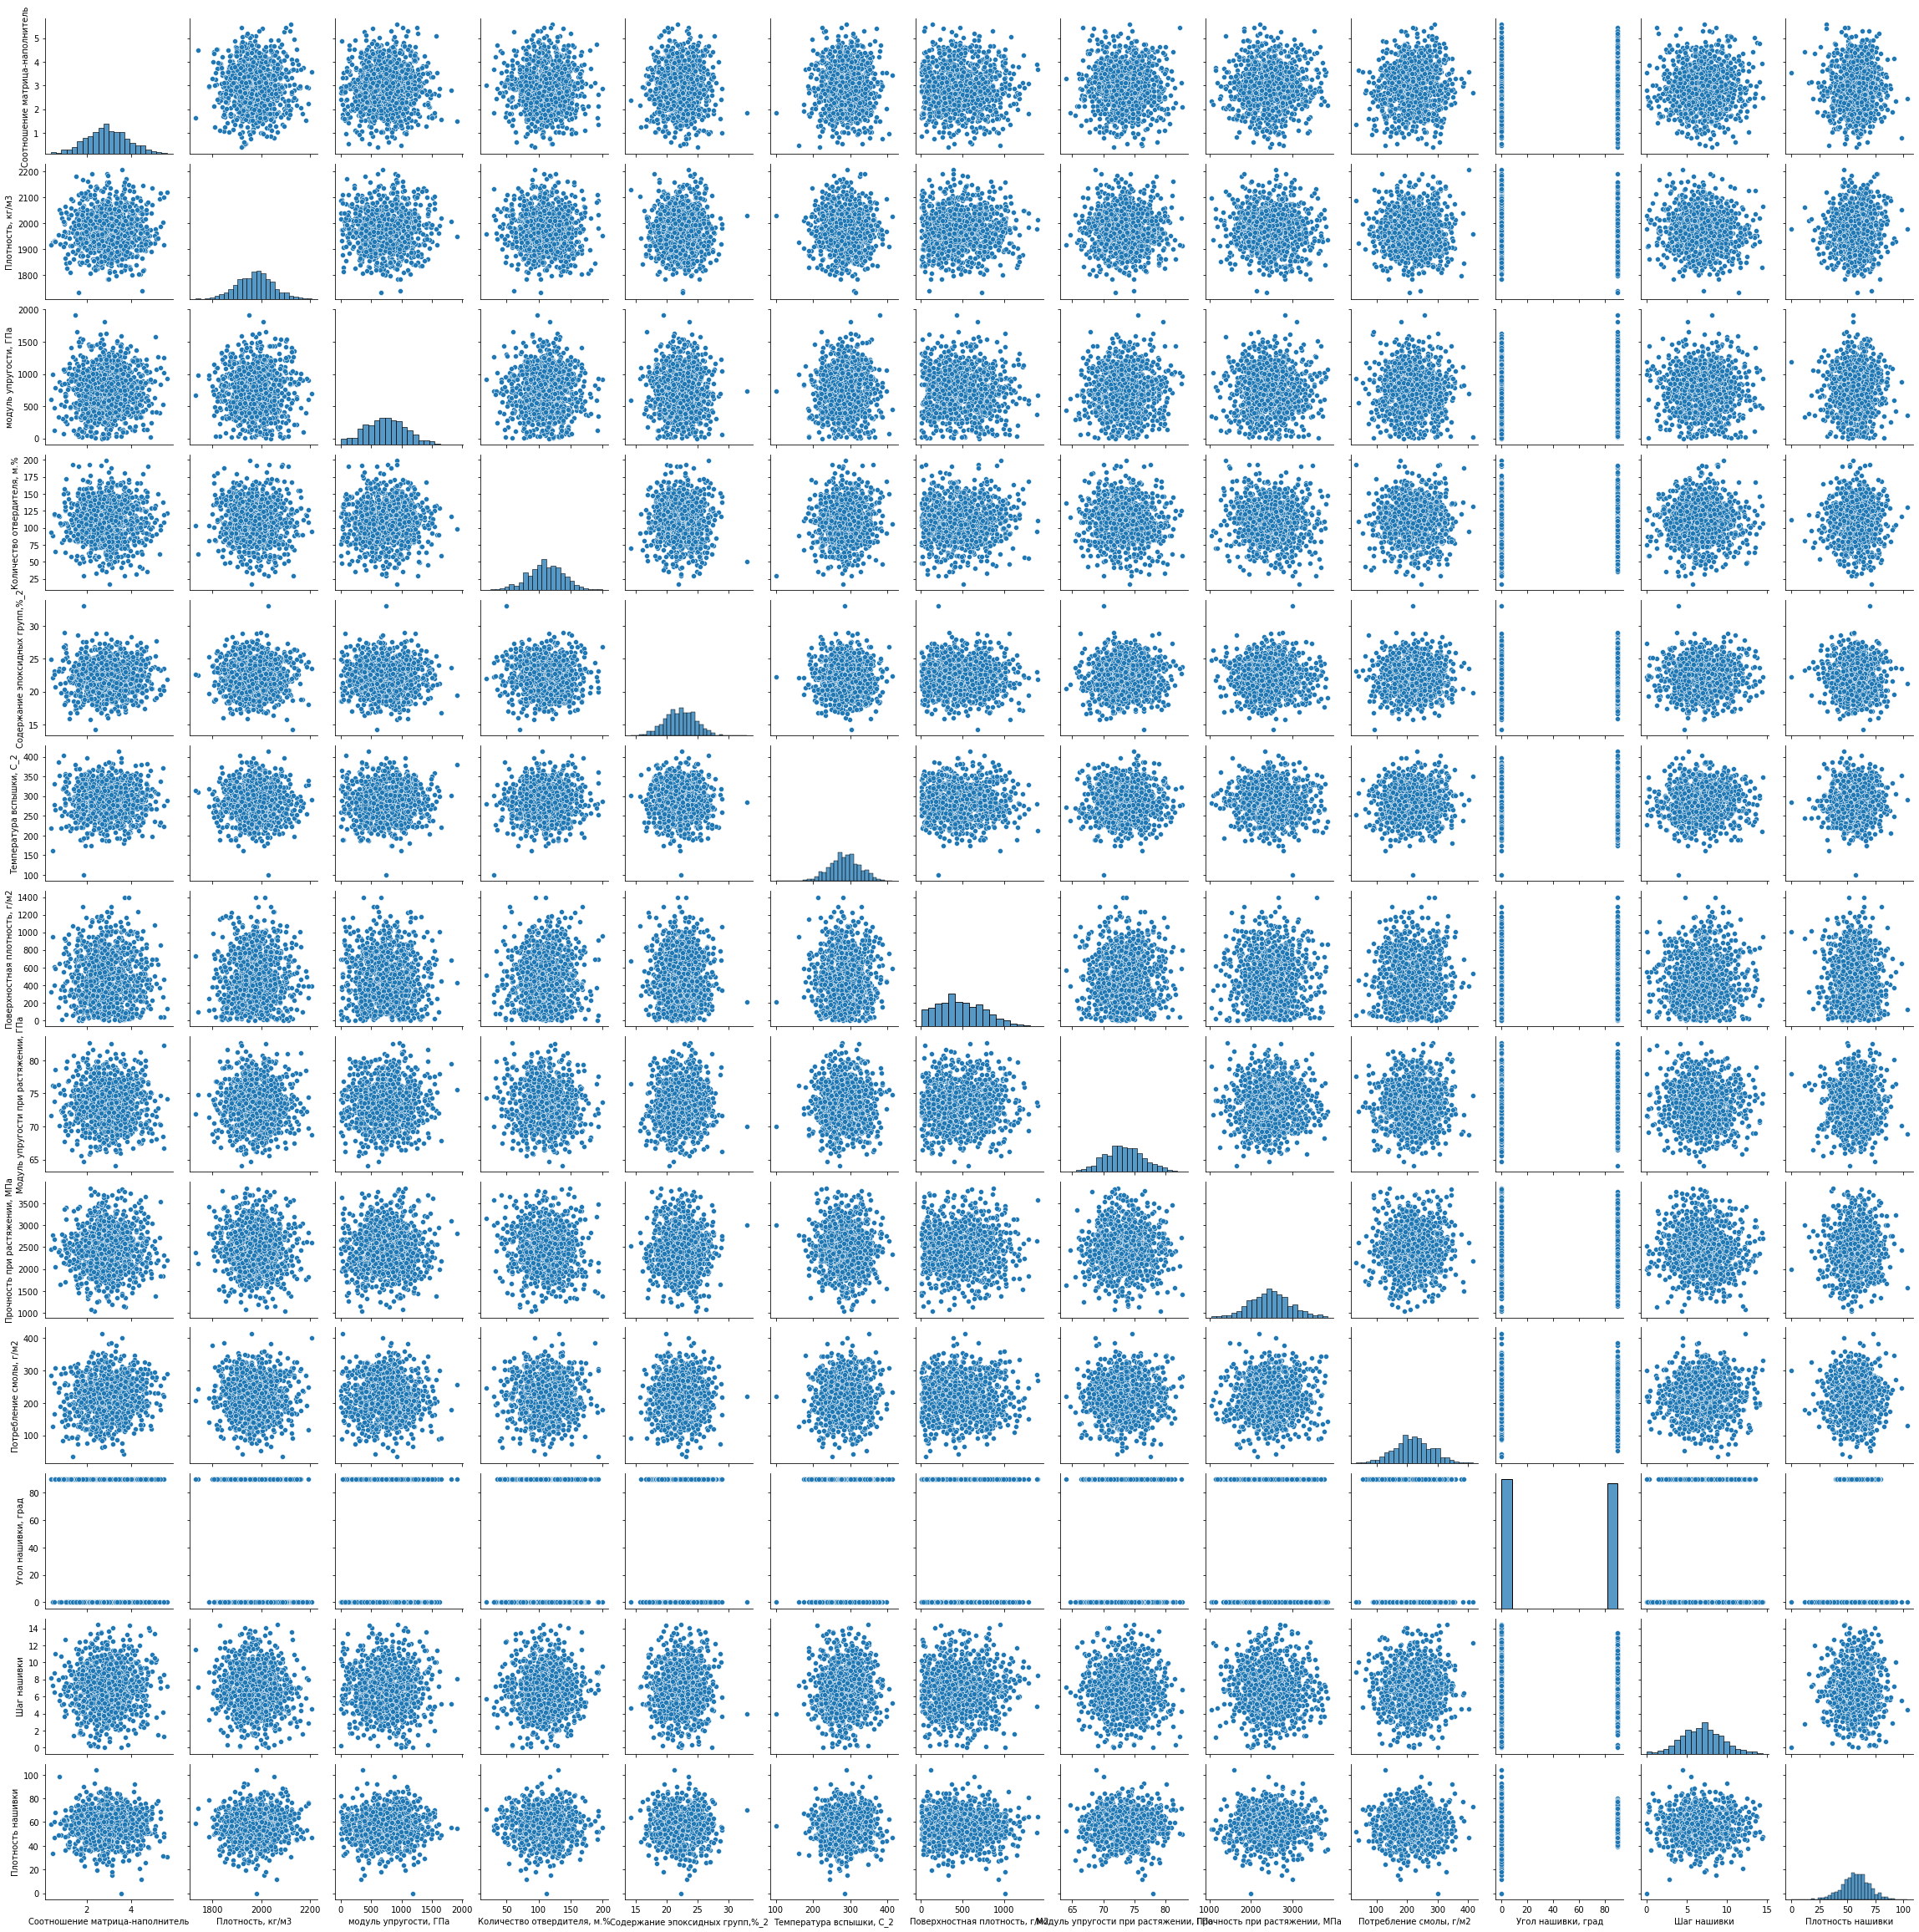

In [16]:
sns_plot = sns.pairplot(df_merge[df_merge.columns])
sns_plot.savefig('pairplot.png')

* попарное сравнение какой-либо корреляции между признаками нет.
* из графиков видно, что выбросы есть. Некоторые точки стоят очень далеко от общего облака

### Шаг 7. Получить среднее, медианное значение для каждой колонки

среднее значение

In [17]:
df_merge.mean()

Соотношение матрица-наполнитель            2.930366
Плотность, кг/м3                        1975.734888
модуль упругости, ГПа                    739.923233
Количество отвердителя, м.%              110.570769
Содержание эпоксидных групп,%_2           22.244390
Температура вспышки, С_2                 285.882151
Поверхностная плотность, г/м2            482.731833
Модуль упругости при растяжении, ГПа      73.328571
Прочность при растяжении, МПа           2466.922843
Потребление смолы, г/м2                  218.423144
Угол нашивки, град                        44.252199
Шаг нашивки                                6.899222
Плотность нашивки                         57.153929
dtype: float64

медианное значение

In [18]:
df_merge.median()

Соотношение матрица-наполнитель            2.906878
Плотность, кг/м3                        1977.621657
модуль упругости, ГПа                    739.664328
Количество отвердителя, м.%              110.564840
Содержание эпоксидных групп,%_2           22.230744
Температура вспышки, С_2                 285.896812
Поверхностная плотность, г/м2            451.864365
Модуль упругости при растяжении, ГПа      73.268805
Прочность при растяжении, МПа           2459.524526
Потребление смолы, г/м2                  219.198882
Угол нашивки, град                         0.000000
Шаг нашивки                                6.916144
Плотность нашивки                         57.341920
dtype: float64

### Шаг 8. Провести анализ

<AxesSubplot:>

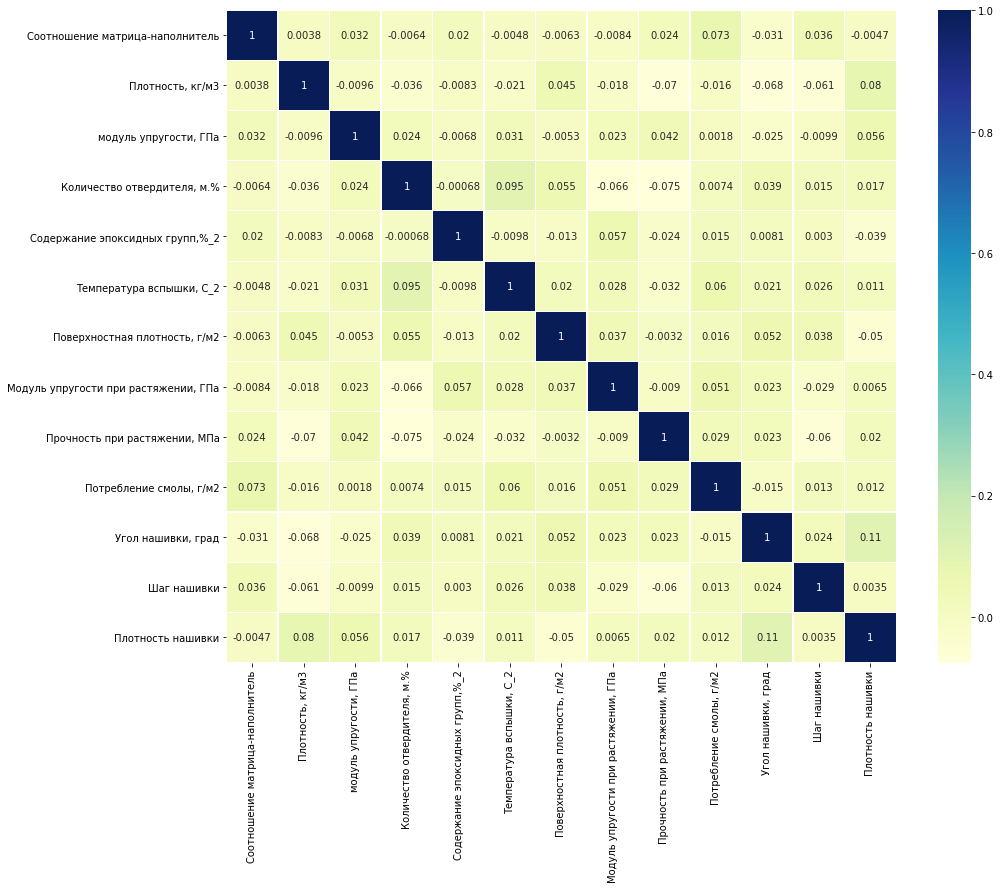

In [19]:
corrmat = df_merge.corr()
  
f, ax = plt.subplots(figsize =(15, 12))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot = True)

Корреляция очень слабая, можно сказать отсутствует. Можно выделить слабую корреляцию между "Плотностью нашивки" и "углом нашивки"

## Предобработку данных

### Шаг 1. Удаление выбросов

Для удаления выбросов существует 2 основных метода - метод 3-х сигм или межквартильных расстояний. Сравним эти 2 метода.

In [20]:
count_3s = 0
count_iq = 0
for column in df_merge:
    d = df_merge.loc[:, [column]]
    # методом 3-х сигм
    zscore = (df_merge[column] - df_merge[column].mean()) / df_merge[column].std()
    d['3s'] = zscore.abs() > 3
    count_3s += d['3s'].sum()
    # методом межквартильных расстояний
    q1 = np.quantile(df_merge[column], 0.25)
    q3 = np.quantile(df_merge[column], 0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    d['iq'] = (df_merge[column] <= lower) | (df_merge[column] >= upper)
    count_iq += d['iq'].sum()
print('Метод 3-х сигм, выбросов:', count_3s)
print('Метод межквартильных расстояний, выбросов:', count_iq)

Метод 3-х сигм, выбросов: 24
Метод межквартильных расстояний, выбросов: 93


Как видно в результате, метод 3-х сигм нашел меньше выбросов. Учитывая тот факт что данные были предварительно подготовлены заказчиком и то, что график "ящик с усами" показывает небольшое количество выбросов и не самый большой размах. С целью того, чтобы избежать удаления тех данных, которые могут оказаться не выбросами, а особенностями датасета, я оставил свой выбор за методом 3-х сигм.

Для того чтобы не допустить ошибки и не удалить особенности признака. Посчитаем распределение выбросов по признакам.

In [21]:
t_df = df_merge.copy()
for i in df_merge.columns:
    t_df[i] = abs((df_merge[i] - df_merge[i].mean()) / df_merge[i].std())
    print(f"{sum(t_df[i] > 3)} выбросов в признаке {i}")
print(f' Всего {sum(sum(t_df.values > 3))} выброса')

0 выбросов в признаке Соотношение матрица-наполнитель
3 выбросов в признаке Плотность, кг/м3
2 выбросов в признаке модуль упругости, ГПа
2 выбросов в признаке Количество отвердителя, м.%
2 выбросов в признаке Содержание эпоксидных групп,%_2
3 выбросов в признаке Температура вспышки, С_2
2 выбросов в признаке Поверхностная плотность, г/м2
0 выбросов в признаке Модуль упругости при растяжении, ГПа
0 выбросов в признаке Прочность при растяжении, МПа
3 выбросов в признаке Потребление смолы, г/м2
0 выбросов в признаке Угол нашивки, град
0 выбросов в признаке Шаг нашивки
7 выбросов в признаке Плотность нашивки
 Всего 24 выброса


Как видно из расчёта, выбросы распределе-ны по разным признакам. Нет какой-либо чрезмерной концентрации в одном признаке. Соответственно можно приступать к удалению признака, так как су-щественных изменений на зависимости они не окажут. 

In [22]:
clean_outliers_df_merge = df_merge[(np.abs(stats.zscore(df_merge)) <= 3).all(axis=1)]
clean_outliers_df_merge

Соотношение матрица-наполнитель  Плотность, кг/м3  \
1.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
5.0                            2.767918       2000.000000   
6.0                            2.569620       1910.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
1.0                738.736842                    50.000000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
5.0                748.000000                   111.860000   
6.0                807.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
1.0                           23.750000                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
5.0                           22.267857                284.615385   
6.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
1.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
5.0                        210.000000                             70.000000   
6.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
1.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
5.0                       3000.000000               220.000000   
6.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

После удаления выбросов. Видно, что количество строк стало 999 (на 24 меньше). Построим матрицу корреляции. Чтобы посмотреть как изменились зависимости, после удаления выбросов.

<AxesSubplot:>

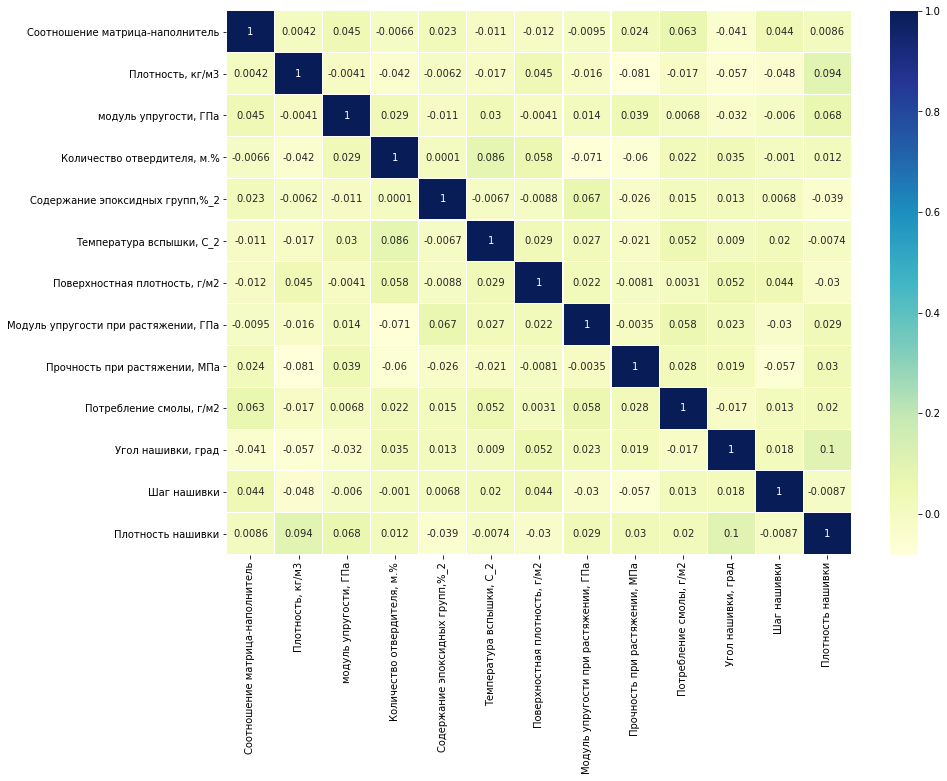

In [23]:
corrmat = clean_outliers_df_merge.corr()
  
f, ax = plt.subplots(figsize =(14, 10))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot = True)

Как видим по графику, в результате удаления выбросов, корреляция изменилась не значительно. Где-то возросла, где-то уменьшилась. Но существенных изменений нет, корреляция между признаками по-прежнему, фактически отсутствует.

In [24]:
#Сохраним очищенный от выбросов датасет в папку Dataset
clean_outliers_df_merge.to_csv('Datasets\Datasets\clean_outliers_df_merge.csv', encoding = 'cp1251' )

### Шаг 2. Нормализация

<AxesSubplot:ylabel='Density'>

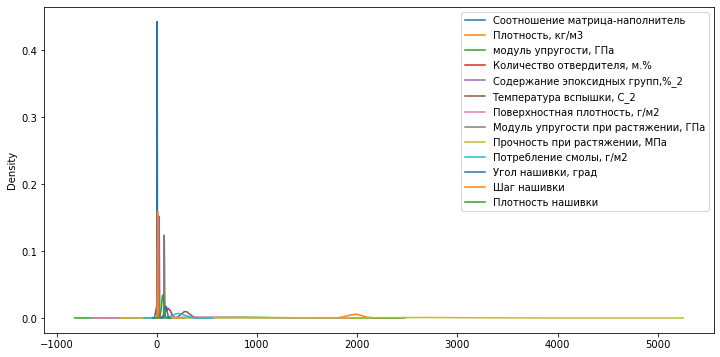

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
clean_outliers_df_merge.plot(kind='kde', ax=ax)

Оценка плотности ядра наглядно показывает, что данные находятся в разных диапазонах. Так как диапазоны слишком разные, данные нужно нормализовать.

In [26]:
mscaler = MinMaxScaler()
normal_df = pd.DataFrame(mscaler.fit_transform(clean_outliers_df_merge), columns=clean_outliers_df_merge.columns, index=clean_outliers_df_merge.index)
normal_df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
1.0                            0.282131          0.601381   
3.0                            0.282131          0.601381   
4.0                            0.457857          0.601381   
5.0                            0.457201          0.527898   
6.0                            0.419084          0.307448   
...                                 ...               ...   
1018.0                         0.361750          0.410540   
1019.0                         0.587163          0.650588   
1020.0                         0.555750          0.460227   
1021.0                         0.637396          0.691520   
1022.0                         0.657131          0.259472   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
1.0                  0.447061                     0.123047   
3.0                  0.447061                     0.608021   
4.0                  0.455721                     0.502800   
5.0                  0.452685                     0.502800   
6.0                  0.488508                     0.502800   
...                       ...                          ...   
1018.0               0.552781                     0.350139   
1019.0               0.268550                     0.712271   
1020.0               0.251612                     0.494656   
1021.0               0.448724                     0.684130   
1022.0               0.251903                     0.609147   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
1.0                            0.607435                  0.482823   
3.0                            0.418887                  0.549664   
4.0                            0.495653                  0.482823   
5.0                            0.495653                  0.482823   
6.0                            0.495653                  0.482823   
...                                 ...                       ...   
1018.0                         0.333908                  0.657301   
1019.0                         0.294428                  0.350746   
1020.0                         0.623085                  0.325580   
1021.0                         0.267818                  0.444436   
1022.0                         0.888354                  0.553803   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
1.0                          0.162230                              0.321894   
3.0                          0.162230                              0.321894   
4.0                          0.162230                              0.321894   
5.0                          0.162230                              0.321894   
6.0                          0.162230                              0.321894   
...                               ...                                   ...   
1018.0                       0.161609                              0.489229   
1019.0                       0.271207                              0.480019   
1020.0                       0.572959                              0.578197   
1021.0                       0.496511                              0.540754   
1022.0                       0.587373                              0.555208   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
1.0                          0.698235                 0.517418   
3.0                          0.698235                 0.517418   
4.0                          0.698235                 0.517418   
5.0                          0.698235                 0.517418   
6.0                          0.698235                 0.517418   
...                               ...                      ...   
1018.0                       0.480312                 0.242759   
1019.0                       0.470745                 0.221717   
1020.0                       0.578340                 0.565435   
1021.0                       0.368070                 0.451281   
1022.0                    

## Разработка и обучение моделей

## прогноз модуля упругости при растяжени

In [27]:
#Входные данные
train = normal_df.drop(['Модуль упругости при растяжении, ГПа',
                        "Прочность при растяжении, МПа"], axis=1)

#выходные переменные
aim = normal_df[['Модуль упругости при растяжении, ГПа']]

In [28]:
#тестовая и обучающая выборки 70/30
X_train, X_test, Y_train, Y_test = train_test_split(train, aim, test_size=0.3, random_state=0)

In [29]:
print("Размер тренировочного датасета на входе:", X_train.shape)
print("Размер тестового датасета на входе:", X_test.shape)
print("Размер тренировочного датасета на выходе:", Y_train.shape)
print("Размертестового датасета на выходе:", Y_test.shape)

Размер тренировочного датасета на входе: (699, 11)
Размер тестового датасета на входе: (300, 11)
Размер тренировочного датасета на выходе: (699, 1)
Размертестового датасета на выходе: (300, 1)


In [30]:
# Сделаем вспомогательную функцию для запуска моделей и получения метрик.
def run_models(models, X, y):
    stat = pd.DataFrame()
    for model_name, model in models.items():
        scoring = ['r2', 
                   'neg_root_mean_squared_error', 
                   'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, cv=10, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean()
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean()
    return stat

In [31]:
#создаем словарь с моделями
models_y = {

    'LinearRegression': LinearRegression(),
    'SGDRegressor': SGDRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),  
}

In [32]:
#получаем оценку моделей
stat = run_models(models_y, X_train, Y_train)
stat.style.highlight_max(axis=0)

C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Как видно из таблицы оценки, все модели не смогли выявить зависимости и предсказать прогноз модуля упругости при растяжении. Лучшие результаты у линейной регрессии. По заданию у нас задача у нас построить моделей и найти лучшие гиперпараметры. Построим для некторых моделей графики и поиск гиперпараметров.

**Линейная регрессия**

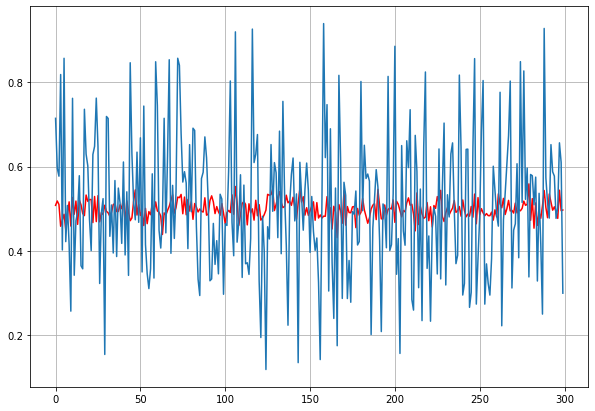

In [33]:
#построение модели и вузуализация
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred_lr = lr.predict(X_test)
plt.figure(figsize=(10, 7))
plt.plot(y_pred_lr, "r", label="prediction")
plt.plot(Y_test.values, label="actual")
plt.grid(True);

Линейная регрессия с задайчей не справилась. Зависимоть не смог найти.

**Метод случайный лес**

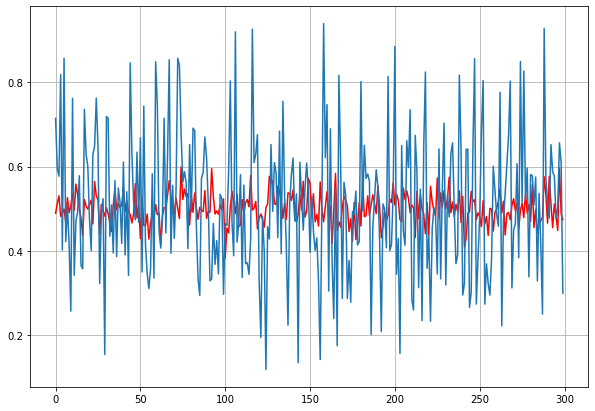

In [34]:
#построение модели и вузуализация
rfr = RandomForestRegressor(n_estimators=1000, max_depth=18)
rfr.fit(X_train, Y_train.values[:, 0])
y_pred_forest = rfr.predict(X_test)
plt.figure(figsize=(10, 7))
plt.plot(y_pred_forest, "r", label="prediction")
plt.plot(Y_test.values, label="actual")
plt.grid(True);


In [35]:
#поиск лучших гиперпараметров
n_estimators = [5,7,9,11,15,20,40]
max_depth = [1,2,3,4,5]
min_samples_split = [23,24,25,26]
min_samples_leaf = [3,4,5,6]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv = 10, verbose = 1, n_jobs=-1)
gs.fit(X_train, Y_train)
rfr_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


C:\Users\teres\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 23,
 'n_estimators': 5}

Случайный лес с задайчей не справился. Зависимоть не смог найти.

**метод К ближайших соседей**

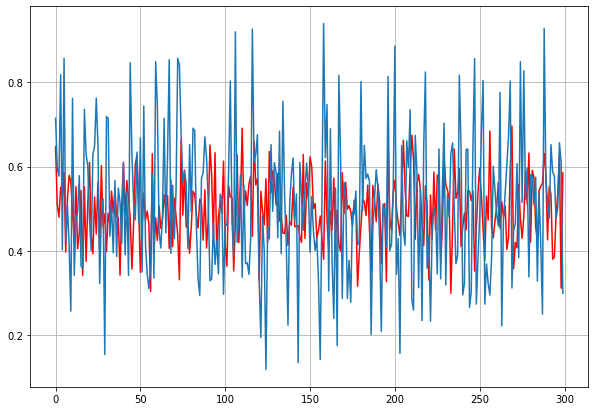

In [36]:
#построение модели и вузуализация
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, Y_train)
y_pred_knn = knn.predict(X_test)
plt.figure(figsize=(10, 7))
plt.plot(y_pred_knn, "r", label="prediction")
plt.plot(Y_test.values, label="actual")
plt.grid(True);

In [37]:
#поиск лучших гиперпараметров
param_grid = {"n_neighbors": range(1, 50)}
gs = GridSearchCV(knn, param_grid, cv = 10, verbose = 1, n_jobs=-1)
gs.fit(X_train, Y_train)
knn_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 49 candidates, totalling 490 fits


{'n_neighbors': 38}

к-ближайших соседей с задайчей не справился. Зависимоть не смог найти.

**Стохастический градиентный спуск (SGD)**

C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


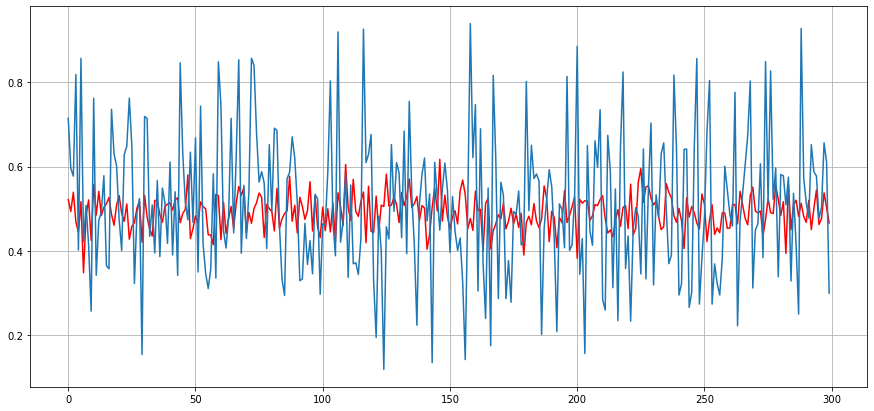

In [38]:
SGDRegressor = SGDRegressor()
SGDRegressor.fit(X_train, Y_train)
y_pred = SGDRegressor.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(y_pred, "r", label="prediction")
plt.plot(Y_test.values, label="actual")
plt.grid(True);

In [39]:
#поиск лучших гиперпараметров
loss = [ 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l2', 'l1', 'elasticnet']
param_grid = {'loss': loss,
               'penalty': penalty}
gs = GridSearchCV(SGDRegressor, param_grid, cv = 10, verbose = 1, n_jobs=-1)
gs.fit(X_train, Y_train)
SGDRegressor_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\teres\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'loss': 'squared_epsilon_insensitive', 'penalty': 'l1'}

стохастический спуск с задайчей не справился. Зависимоть не смог найти. 

**Вывод:** Модуль упругости не имеет линейной зависимости. Линейная регрессия, случайный лес, Стохастический градиентный спуск и метод К ближайших соседей не справились с задачей, что видно из оценки моделей и графиков. Свойства композитных материалов в первую очередь зависят от используемых материалов.

## Прогноз прочности при растяжении


In [40]:
#Входные данные
train2 = normal_df.drop(['Модуль упругости при растяжении, ГПа',
                        "Прочность при растяжении, МПа"], axis=1)

#выходные переменные
aim2 = normal_df[['Прочность при растяжении, МПа']]

In [41]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(train2, aim2, test_size=0.3, random_state=0)

In [42]:
print("Размер тренировочного датасета на входе:", X_train2.shape)
print("Размер тестового датасета на входе:", X_test2.shape)
print("Размер тренировочного датасета на выходе:", Y_train2.shape)
print("Размертестового датасета на выходе:", Y_test2.shape)

Размер тренировочного датасета на входе: (699, 11)
Размер тестового датасета на входе: (300, 11)
Размер тренировочного датасета на выходе: (699, 1)
Размертестового датасета на выходе: (300, 1)


In [43]:
#создаем словарь с моделями
models_y2 = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()    
}

In [44]:
#получаем оценку моделей
stat = run_models(models_y2, X_train2, Y_train2)
stat.style.highlight_max(axis=0)

C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Как видно видно из таблицы оценки, все модели не смогли выявить зависимости и не смогли предсказать Прогноз прочности при растяжении. Лучшие результаты у линейной регрессии. По заданию у нас задача у нас построить моделей и найти лучшие гиперпараметры. Построим для некторых моделей графики и поиск гиперпараметров.

**Метод линейная регрессия**

In [45]:
lr = LinearRegression()
lr.fit(X_train2, Y_train2)
y_pred = lr.predict(X_test2)

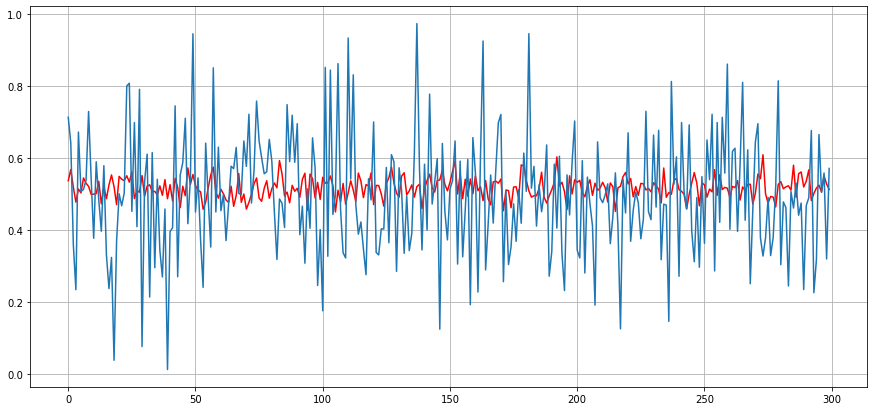

In [46]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred, "r", label="prediction")
plt.plot(Y_test2.values, label="actual")
plt.grid(True);

ленйная регрессия с задайчей не справилась. Зависимоть не смог найти.

**Деревья решений**

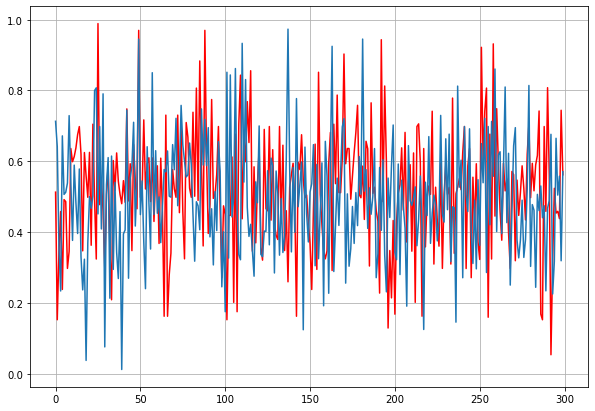

In [47]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train2, Y_train2.values[:, 0])
y_pred_dtr = dtr.predict(X_test)
plt.figure(figsize=(10, 7))
plt.plot(y_pred_dtr, "r", label="prediction")
plt.plot(Y_test2.values, label="actual")
plt.grid(True);

In [48]:
#поиск лучших гиперпараметров
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_leaf = [100,150,200]
min_samples_split = [200,250,300]
max_features = ['auto', 'sqrt', 'log2']
param_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
gs = GridSearchCV(dtr, param_grid, cv = 10, verbose = 1, n_jobs=-1)
gs.fit(X_train2, Y_train)
dtr_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


{'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'min_samples_split': 200,
 'splitter': 'random'}

Деревья решений с задачей не справились. Зависимоть не смог найти.

**Градиентный бустинг**

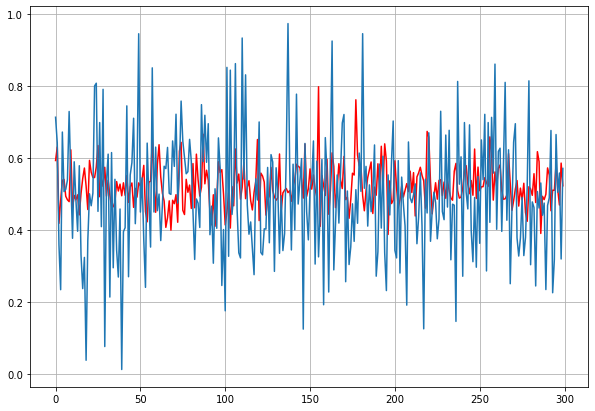

In [49]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train2, Y_train2.values[:, 0])
y_pred_gbr = gbr.predict(X_test)
plt.figure(figsize=(10, 7))
plt.plot(y_pred_gbr, "r", label="prediction")
plt.plot(Y_test2.values, label="actual")
plt.grid(True);

In [50]:
#поиск лучших гиперпараметров
loss = ['squared_error', 'absolute_error', 'huber', 'quantile']
n_estimators = [10,20,40,60]
criterion = ['friedman_mse', 'squared_error', 'mse', 'mae']
min_samples_split = [4,5,6,7]
max_depth = [2,4,6,8]
param_grid = {'loss': loss,
               'n_estimators': n_estimators,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'max_depth': max_depth}
gs = GridSearchCV(gbr, param_grid, cv = 10, verbose = 1, n_jobs=-1)
gs.fit(X_train2, Y_train)
gbr_3 = gs.best_estimator_
gs.best_params_

Fitting 10 folds for each of 1024 candidates, totalling 10240 fits


C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1854: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
C:\Users\teres\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\teres\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  warnings.warn(
C:\Users\teres\anaconda3\lib\site-packages\sklearn\tree\_classes.py:366: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is eq

{'criterion': 'mae',
 'loss': 'absolute_error',
 'max_depth': 2,
 'min_samples_split': 6,
 'n_estimators': 10}

градиентный бустинг с задайчей не справился. Зависимоть не смог найти.

Вывод: Прочность при растяжении не имеет линейной зависимости. Линейная регрессия, деревья решений, грдиентный бустинг не справились с задачей. Прочность при растяжении завист от методики проверки материала. Одному значению прочность при растяжении, могут соответствовать множество материалов в различных экспериментах.

## Нейронная сеть, рекомендации соотношения матрица-наполнитель.

In [27]:
#создание выборки
#формирование выборок
input_columns_names = ["Модуль упругости при растяжении, ГПа",
                      "Прочность при растяжении, МПа",
                      "Плотность, кг/м3",
                      "модуль упругости, ГПа",
                      "Количество отвердителя, м.%",
                      "Содержание эпоксидных групп,%_2",
                      "Температура вспышки, С_2",
                      "Поверхностная плотность, г/м2",
                      "Потребление смолы, г/м2",
                      "Угол нашивки, град",
                      "Шаг нашивки",
                      "Плотность нашивки"]

output_columns_names = ["Соотношение матрица-наполнитель"]
                    
x = normal_df[input_columns_names]
y = normal_df[output_columns_names]

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [29]:
#создание модели
model = keras.Sequential(
    [
    layers.Dense(64, activation = 'relu', input_dim=12),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1),
    ]
)

model.compile(optimizer='adam', 
              loss='mse', 
              metrics='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1997
Epoch 2/100
25/25 [==============================] - 0s 832us/step - loss: 0.0346 - mae: 0.1499
Epoch 3/100
25/25 [==============================] - 0s 1000us/step - loss: 0.0313 - mae: 0.1422
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0309 - mae: 0.1407
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0307 - mae: 0.1408
Epoch 6/100
25/25 [==============================] - 0s 875us/step - loss: 0.0298 - mae: 0.1389
Epoch 7/100
25/25 [==============================] - 0s 1000us/step - loss: 0.0307 - mae: 0.1401
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 0.0294 - mae: 0.1381
Epoch 9/100
25/25 [==============================] - 0s 917us/step - loss: 0.0294 - mae: 0.1379
Epoch 10/100
25/25 [==============================] - 0s 917us/step - loss: 0.0289 - mae: 0.1366
Epoch 11/100
25/25 [=========================

In [31]:
#результат работы нейронной сети на тестовой выборке
score = model.evaluate(x_test, y_test, verbose=0)
print('mse:', score[0])
print('mae', score[1])

mse: 0.0535467229783535
mae 0.18667000532150269


In [32]:
#сохраним модель
model.save('Datasets\model')

INFO:tensorflow:Assets written to: Datasets\model\assets


In [33]:
x_test.shape

(200, 12)

In [34]:
y_pred = model.predict(x_test)
y_pred

array([[ 0.56308115],
       [ 0.46769568],
       [ 0.3781329 ],
       [ 0.4523953 ],
       [ 0.3734354 ],
       [ 0.29121688],
       [ 0.46037266],
       [ 0.636858  ],
       [ 0.43424848],
       [ 0.30570415],
       [ 0.35174254],
       [ 0.46592054],
       [ 0.60583967],
       [ 0.5206038 ],
       [ 0.5714741 ],
       [ 0.40298474],
       [ 0.7047943 ],
       [ 0.3854958 ],
       [ 0.38392887],
       [ 0.48140803],
       [ 0.5774132 ],
       [ 0.68317264],
       [ 0.5725211 ],
       [ 0.69256866],
       [ 0.47499081],
       [ 0.3624522 ],
       [ 0.4639183 ],
       [ 0.68296266],
       [ 0.63460016],
       [ 0.4764165 ],
       [ 0.4114377 ],
       [ 0.45333597],
       [ 0.5688202 ],
       [ 0.41654012],
       [ 0.50362676],
       [ 0.516106  ],
       [ 0.4170309 ],
       [ 0.49979147],
       [ 0.40928128],
       [ 0.5664479 ],
       [ 0.46930963],
       [ 0.46044615],
       [ 0.32085985],
       [ 0.35333726],
       [ 0.37314072],
       [ 0

In [36]:
y_pred.reshape(x_test.shape[0])

array([ 0.56308115,  0.46769568,  0.3781329 ,  0.4523953 ,  0.3734354 ,
        0.29121688,  0.46037266,  0.636858  ,  0.43424848,  0.30570415,
        0.35174254,  0.46592054,  0.60583967,  0.5206038 ,  0.5714741 ,
        0.40298474,  0.7047943 ,  0.3854958 ,  0.38392887,  0.48140803,
        0.5774132 ,  0.68317264,  0.5725211 ,  0.69256866,  0.47499081,
        0.3624522 ,  0.4639183 ,  0.68296266,  0.63460016,  0.4764165 ,
        0.4114377 ,  0.45333597,  0.5688202 ,  0.41654012,  0.50362676,
        0.516106  ,  0.4170309 ,  0.49979147,  0.40928128,  0.5664479 ,
        0.46930963,  0.46044615,  0.32085985,  0.35333726,  0.37314072,
        0.4041476 ,  0.5259912 ,  0.38850307,  0.7343436 ,  0.25847715,
        0.53222954,  0.49720514,  0.5482848 ,  0.3579254 ,  0.30532548,
        0.46950945,  0.23759039,  0.2923745 ,  0.32882008,  0.5110334 ,
        0.31364146,  0.67685914,  0.41452828,  0.5390666 ,  0.32072452,
        0.2959997 ,  0.4784054 ,  0.6196191 ,  0.42401496,  0.76

In [37]:
x_test.head(1)

Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
767.0                              0.514618                       0.710229   

       Плотность, кг/м3  модуль упругости, ГПа  Количество отвердителя, м.%  \
767.0          0.471239               0.381601                     0.654678   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
767.0                         0.703749                  0.466432   

       Поверхностная плотность, г/м2  Потребление смолы, г/м2  \
767.0                       0.457306                 0.557046   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
767.0                 1.0     0.273725           0.311304

In [ ]:
from flask import Flask, request, render_template
from keras.models import load_model
import pandas as pd

app = Flask(__name__)


@app.route('/', methods=['GET', 'POST'])
def compute():
    result = ''
    error = dict()
    if request.method == 'POST':
        data = request.form
        try:
            data1 = {k:[float(v)] for k,v in data.items()}
        except ValueError:
            for k,v in data.items():
                try:
                    float(v)
                except ValueError:
                    error['name'] = k
                    error['value'] = v
                    break
        if not error:
            input = pd.DataFrame(data=data1)
            result = model.predict(input)[0][0]
    return render_template('index.html', result=result, error=error)


if __name__ == '__main__':
    model = load_model('Datasets/model')
    app.run()
